In [1]:
import pandas as pd
import numpy as np
import unittest2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.preprocessing import StandardScaler



ModuleNotFoundError: No module named 'unittest2'

In [15]:
datos_originales_conjunto_1 = pd.read_csv('Y_modificado.csv')
datos_originales_conjunto_1

,indice,Date,Price
0,0,2006-11-07,555.00
1,1,2006-12-07,555.00
2,2,2006-07-13,555.00
3,3,2006-07-14,555.00
4,4,2006-07-17,555.00
...,...,...,...
4480,4480,2023-06-09,552.50
4481,4481,2023-07-09,550.00
4482,4482,2023-08-09,545.00
4483,4483,2023-11-09,546.00


In [16]:
df = datos_originales_conjunto_1
# Convertir la columna 'fecha' a tipo datetime
df['Date'] = pd.to_datetime(df['Date'])

# Establecer la columna 'fecha' como índice
df.set_index('Date', inplace=True)


In [17]:
# las fechas están en desorden. Las ordenamos desde la "menor" fecha a la "mayor" (recordadndo que es DateTime)
df = df.sort_index()
df.shape

(4485, 2)

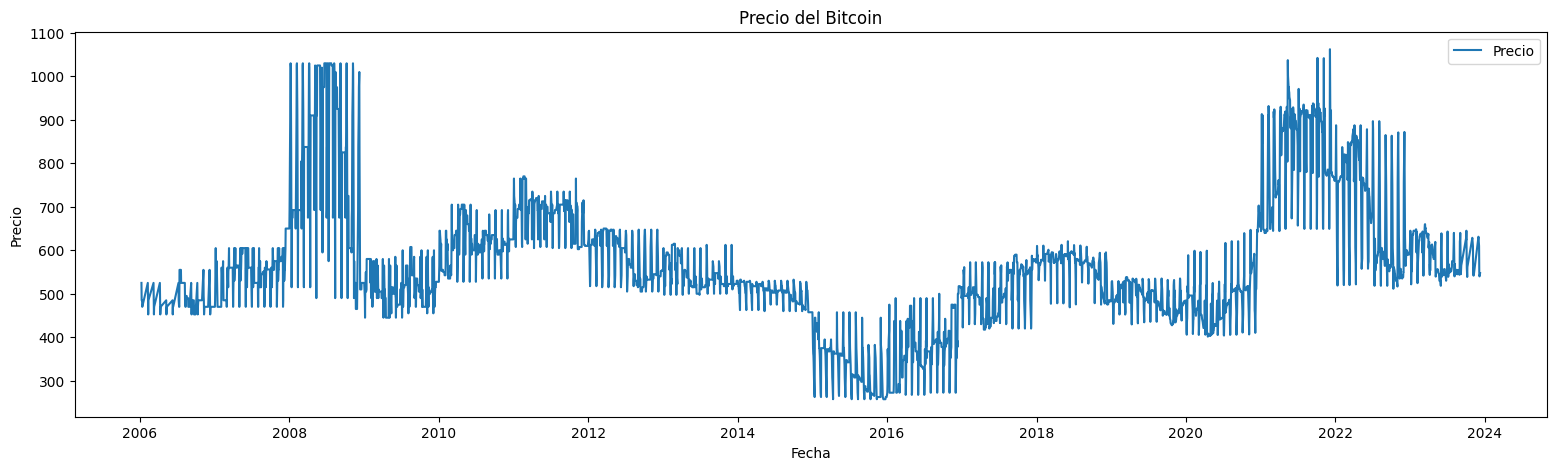

In [18]:
plt.figure(figsize=(19, 5))
plt.plot(df['Price'], label='Precio')
plt.title('Precio del Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

Error cuadrático medio (MSE): 1072.3227666171872


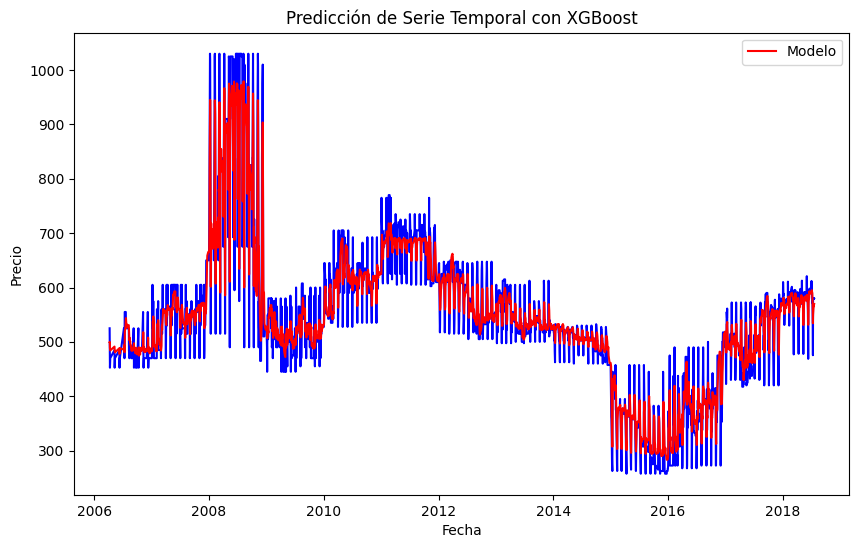

In [19]:
# Crear características de serie temporal (lag features)
def create_lag_features(df, lags=5):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['Price'].shift(lag)
    df = df.dropna()  # Eliminar filas con valores nulos
    return df

# Crear características de lag
df = create_lag_features(df, lags=10)

# Dividir los datos en conjunto de entrenamiento y prueba
train_size = int(len(df) * 0.7)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Separar las características (X) y el target (y)
X_train = train.drop(columns=['Price'])
y_train = train['Price']
X_test = test.drop(columns=['Price'])
y_test = test['Price']

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=3000, max_depth=4, learning_rate=0.001, colsample_bytree=0.3, reg_alpha=0.1, reg_lambda=0.1)

# Entrenar el modelo
model.fit(X_train_scaled, y_train)

# Hacer predicciones
predictions = model.predict(X_train_scaled)

# Convertir las predicciones a un DataFrame
futuros = pd.DataFrame(predictions, index=train.index, columns=['Prediction'])


# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_train, predictions)
print(f"Error cuadrático medio (MSE): {mse}")

# Graficar las predicciones y los valores reales
plt.figure(figsize=(10, 6))
plt.plot(train.index, y_train, label='', color='blue')
plt.plot(train.index, predictions, label='Modelo', color='red')
plt.title('Predicción de Serie Temporal con XGBoost')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()



In [20]:
df

,indice,Price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
Date,,,,,,,,,,,,
2006-04-08,18,525.00,470.00,452.50,525.00,485.00,452.50,525.00,470.00,485.00,485.00,525.00
2006-04-09,39,485.00,525.00,470.00,452.50,525.00,485.00,452.50,525.00,470.00,485.00,485.00
2006-04-10,61,452.50,485.00,525.00,470.00,452.50,525.00,485.00,452.50,525.00,470.00,485.00
2006-04-12,104,470.00,452.50,485.00,525.00,470.00,452.50,525.00,485.00,452.50,525.00,470.00
2006-05-09,40,485.00,470.00,452.50,485.00,525.00,470.00,452.50,525.00,485.00,452.50,525.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04,4375,610.00,631.18,546.00,560.00,541.67,550.00,610.00,628.68,561.67,538.67,560.00
2023-12-05,4397,550.00,610.00,631.18,546.00,560.00,541.67,550.00,610.00,628.68,561.67,538.67
2023-12-06,4418,540.00,550.00,610.00,631.18,546.00,560.00,541.67,550.00,610.00,628.68,561.67


In [21]:
# Hacer que futuros cuente el index como una columna
futuros.reset_index(level=0, inplace=True)
futuros = futuros.rename(columns={'Prediction': 'Price'})
futuros

,Date,Price
0,2006-04-08,499.466278
1,2006-04-09,500.148010
2,2006-04-10,488.556519
3,2006-04-12,484.254791
4,2006-05-09,491.364807
...,...,...
3127,2018-07-16,562.680481
3128,2018-07-17,568.185547
3129,2018-07-18,565.431702
3130,2018-07-19,568.874451


In [22]:

import skforecast
import sklearn
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.feature_selection import select_features
from skforecast.preprocessing import RollingFeatures
import shap


In [ ]:
# Create forecaster
# ==============================================================================
end_validation = '2023-12-09'

window_features = RollingFeatures(stats=["coef_variation"], window_sizes=4200)
forecaster = ForecasterRecursive(
                regressor       = XGBRegressor(random_state=15926, enable_categorical=True),
                lags            = 3000,
                window_features = window_features
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df.loc[:end_validation, 'Price'])



c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1157: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1157: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


AttributeError: 'ForecasterRecursive' object has no attribute 'regressor_'

In [ ]:
final = forecaster.predict(steps=365)
final


c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1219: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


4200    566.397827
4201    590.333923
4202    592.515259
4203    605.981201
4204    577.182922
           ...    
4560    590.674866
4561    577.512451
4562    594.977112
4563    557.671326
4564    593.407837
Name: pred, Length: 365, dtype: float64

In [34]:
# incertidumbre para reportar cada medida la calculamos así:
std = final.std()
std
print(13.94*0.9)

12.546


### predicción 2 años

In [25]:
'''
graficar SOLAMENTE las predicciones futuras
plt.figure(figsize=(10, 6))
plt.plot(future.index, future['Prediction'], label='Predicción Futura', color='red')
plt.title('Futuro de la materia prima X')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()
'''
final_2_anios = forecaster.predict(steps=730)
final_2_anios

c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1219: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


4200    566.397827
4201    590.333923
4202    592.515259
4203    605.981201
4204    577.182922
           ...    
4925    589.224304
4926    575.548096
4927    587.991333
4928    586.022583
4929    586.067871
Name: pred, Length: 730, dtype: float64

In [26]:
final_3_anios = forecaster.predict(steps=1095)
final_3_anios

c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1219: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


4200    566.397827
4201    590.333923
4202    592.515259
4203    605.981201
4204    577.182922
           ...    
5290    580.736938
5291    582.404724
5292    570.532104
5293    568.620544
5294    569.291931
Name: pred, Length: 1095, dtype: float64

---

In [ ]:
# save as csv (modify the index to be the date)
final_3_anios.to_csv('final_3_anios.csv', index=True)

---